In [1]:
import numpy as np
import os
import librosa
import librosa.display
import pandas as pd
from IPython import display
from matplotlib import pyplot
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
# A simple wrapper class for (1-channel) audio data
# data is a 1-D NumPy array containing the data
# rate is a number expressing the samples per second
class Audio:
    def __init__(self, data, rate):
        self.data = data
        self.rate = rate
    def play(self):
        return display.Audio(self.data, rate=self.rate)
    def plot_wave(self):
        librosa.display.waveplot(self.data, sr=self.rate)
    def plot_spectrum(self):
        n_fft = int(self.rate / 20)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(self.data, n_fft)), ref=np.max)
        librosa.display.specshow(D, y_axis='linear', sr=self.rate, hop_length=n_fft/4)
    @classmethod
    def fromfile(cls, fn):
        return cls(*librosa.load(fn, sr=None))

In [9]:
# dataset directory, put the DoV dataset under the path 'data'
datasubdir = 'data/raw'
datadir = os.path.join(os.path.abspath('.'), datasubdir)

In [10]:
subject_names = ['s'+str(i) for i in range(1,10+1)]  # 10 subjects(person)
# 2 rooms: downstairs/upstairs, 2 device placement: against wall, away from wall, 2 sessions: trail1, trail2
trial_names_base = [f'{t}_trial{i}' for t in ['downstairs_nowall', 'downstairs_wall', 'upstairs_nowall', 'upstairs_wall']
                                    for i in range(1,3)]
trial_names = [os.path.join(s, s + '_' + t) 
               for s in subject_names
               for t in trial_names_base]

# 3 user distance * 3 polar positions
angle_names = [alph[0] + num[0] + '_' + alph[1] + '_' + num[1]  
               for alph in [('A', '1'), ('B', '3'), ('C', '5')]
               for num in [(str(i),str(45*i)) for i in range(3)]]

# recording path: 10 person*2 rooms*2 deviceplacement*2 sessions *3 distance *3 polar positions = 720 paths
# each path includ 8 angles * 2  utterances
# total recording: 720*8*2=11520
recording_paths = [os.path.join(datadir, t,a) for t in trial_names 
                                              for a in angle_names]
recording_paths_rel = [(s,t,a) for s in subject_names
                               for t in trial_names_base 
                               for a in angle_names]

# print(len(recording_paths_rel) == len(recording_paths))
# print(*zip(recording_paths_rel, recording_paths))
# print(os.listdir(recording_paths[0]))

In [11]:
# Credit to Yihui Xiong, 2017, https://github.com/xiongyihui/tdoa/blob/master/gcc_phat.py

def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method.
    '''
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = shift / float(interp * fs)
    
    return tau, cc

In [12]:
# prepare for the feature column
# first 4 colums are information of the audio, the rest are GCC-PHAT features
colnames = ['sample', 'trial', 'angle_pos', 'dov',
                        *[f'gccphat_{i}_{j}_{d}' for i in range(4) for j in range(i+1,4) for d in ['maxshift', 'auc', 'peakval']],
                        *[f'gccphatval_{i}_{j}_{k}' for i in range(4) for j in range(i+1,4) for k in range(23)]]

In [13]:
def get_featurized_data(recording_num):
    df = pd.DataFrame(columns=colnames)
    for pth_ind in range(len(recording_paths)):
        for angle in map(lambda i:45*i, range(360//45)):
            channel_recordings = [os.path.join(recording_paths[pth_ind], f'recording{recording_num}_{angle}_{i}.wav') for i in range(1,5)]
            audio_files = [Audio.fromfile(r) for r in channel_recordings]
            four_channels = [a.data for a in audio_files]
            data_row = {
                'sample': recording_paths_rel[pth_ind][0],
                'trial': recording_paths_rel[pth_ind][1],
                'angle_pos': recording_paths_rel[pth_ind][2],
                'dov': angle 
            }        
            for i in range(4):
                for j in range(i+1,4):
                    gcc_phat_data = gcc_phat(four_channels[i], four_channels[j], 
                                          fs = audio_files[0].rate, max_tau=0.236 * 1e-3, interp=1)
                    data_row[f'gccphat_{i}_{j}_peakval'] = gcc_phat_data[1][11]
                    data_row[f'gccphat_{i}_{j}_auc'] = np.sum(gcc_phat_data[1])
                    data_row[f'gccphat_{i}_{j}_maxshift'] = gcc_phat_data[0]
                    for k in range(23):
                        data_row[f'gccphatval_{i}_{j}_{k}'] = gcc_phat_data[1][k]
            data_rows.append(data_row)
            df = df.append(data_row, ignore_index=True)
    return df

In [14]:
data_rows = []
df = pd.DataFrame(columns=colnames)
for pth_ind in range(len(recording_paths)):
    for angle in map(lambda i:45*i, range(360//45)):
    # 8 angles for 1 utterance(recording0)
        channel_recordings = [os.path.join(recording_paths[pth_ind], f'recording0_{angle}_{i}.wav') for i in range(1,5)]
        audio_files = [Audio.fromfile(r) for r in channel_recordings]
        four_channels = [a.data for a in audio_files]
        data_row = {
            'sample': recording_paths_rel[pth_ind][0],
            'trial': recording_paths_rel[pth_ind][1],
            'angle_pos': recording_paths_rel[pth_ind][2],
            'dov': angle 
        }
        
        # for each angle recording, it contain 4 channels audio from the mic array to calculate the GCC-PHAT
        # 6 cross coralations between 4 channels, each feature contain: (peakval,auc,maxshift and 23 values of gcc-phat)*6 cross corelations = 156
        for i in range(4):
            for j in range(i+1,4):
                gcc_phat_data = gcc_phat(four_channels[i], four_channels[j], 
                                      fs = audio_files[0].rate, max_tau=0.236 * 1e-3, interp=1)
                data_row[f'gccphat_{i}_{j}_peakval'] = gcc_phat_data[1][11]
                data_row[f'gccphat_{i}_{j}_auc'] = np.sum(gcc_phat_data[1])
                data_row[f'gccphat_{i}_{j}_maxshift'] = gcc_phat_data[0]
                for k in range(23):
                    data_row[f'gccphatval_{i}_{j}_{k}'] = gcc_phat_data[1][k]
        data_rows.append(data_row)
        df = df.append(data_row, ignore_index=True)

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\3854186740.py:17: RuntimeWarning: invalid value encountered in true_divide
  cc = np.fft.irfft(R / np.abs(R), n=(interp * n))
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: Futu

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\3854186740.py:17: RuntimeWarning: invalid value encountered in true_divide
  cc = np.fft.irfft(R / np.abs(R), n=(interp * n))
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: Futu

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\3854186740.py:17: RuntimeWarning: invalid value encountered in true_divide
  cc = np.fft.irfft(R / np.abs(R), n=(interp * n))
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: Futu

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\3854186740.py:17: RuntimeWarning: invalid value encountered in true_divide
  cc = np.fft.irfft(R / np.abs(R), n=(interp * n))
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: Futu

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\Users\xuwanyan\AppData\Local\Temp\ipykernel_24772\611322203.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data_row, ignore_index=True)
C:\U

In [15]:
# all the feature for recording0(5760)
# 160 columns = 4 information + 156 GCC-PHAT features
df

,sample,trial,angle_pos,dov,gccphat_0_1_maxshift,gccphat_0_1_auc,gccphat_0_1_peakval,gccphat_0_2_maxshift,gccphat_0_2_auc,gccphat_0_2_peakval,...,gccphatval_2_3_13,gccphatval_2_3_14,gccphatval_2_3_15,gccphatval_2_3_16,gccphatval_2_3_17,gccphatval_2_3_18,gccphatval_2_3_19,gccphatval_2_3_20,gccphatval_2_3_21,gccphatval_2_3_22
0,s1,downstairs_nowall_trial1,A0_1_0,0,0.0,0.929901,0.918024,-0.000125,0.802662,-0.081439,...,0.000874,0.057902,0.000011,0.001541,-0.052348,0.000403,0.000849,0.023651,0.000048,0.001163
1,s1,downstairs_nowall_trial1,A0_1_0,45,0.0,0.935565,0.861144,-0.000125,0.829486,-0.119773,...,0.000171,-0.050401,0.000652,0.000966,0.017136,0.000918,-0.000259,-0.035492,0.000443,0.000769
2,s1,downstairs_nowall_trial1,A0_1_0,90,0.0,0.977008,0.580438,-0.000063,0.830345,0.062272,...,-0.000743,-0.00779,-0.000195,0.001031,0.055236,0.002341,-0.001265,-0.038105,-0.000551,0.000891
3,s1,downstairs_nowall_trial1,A0_1_0,135,0.0,0.909018,0.372427,-0.000063,0.8728,0.160522,...,-0.001413,0.076345,-0.000457,0.001607,0.070554,0.003886,-0.000515,-0.046689,-0.001151,0.001109
4,s1,downstairs_nowall_trial1,A0_1_0,180,0.0,0.897188,0.428891,-0.000063,0.823948,0.131519,...,-0.000334,0.157349,0.002033,0.001508,0.063899,-0.000289,0.000181,-0.036023,0.000971,0.000908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,s10,upstairs_wall_trial2,C2_5_90,135,0.000063,0.857919,0.175195,-0.000125,0.83185,0.147013,...,0.003173,0.234129,0.002955,0.000405,0.086957,-0.000108,0.001492,-0.00656,0.00352,-0.000462
5756,s10,upstairs_wall_trial2,C2_5_90,180,0.000063,0.82442,0.149706,0.000125,0.800224,0.145395,...,0.000621,0.188461,0.001892,0.001979,0.131756,0.00159,0.000508,-0.009092,0.001447,0.001046
5757,s10,upstairs_wall_trial2,C2_5_90,225,0.000063,0.84993,0.13706,0.000125,0.807234,0.140276,...,0.00288,0.178562,0.002998,0.000969,0.111268,0.000741,0.00144,0.034045,0.000169,0.000035
5758,s10,upstairs_wall_trial2,C2_5_90,270,-0.000063,0.86961,0.129437,0.000125,0.840994,0.152063,...,0.00167,0.238013,0.002935,0.001225,0.138061,0.002836,0.000815,0.01254,0.000175,0.000875


In [16]:
df.to_csv('data/featurized_data.csv', index=False)

In [29]:
df = pd.read_csv('data/featurized_data.csv')

In [51]:
recordings_of_interest_0 = [os.path.join(recording_paths[0], f'recording0_0_{i}.wav') for i in range(1,5)]
audio_files_0 = [Audio.fromfile(r) for r in recordings_of_interest_0]
four_channels_0 = [a.data for a in audio_files_0]
gcc_phat_data_0 = [gcc_phat(four_channels_0[i],four_channels_0[j], fs = audio_files_0[0].rate, max_tau=0.236 * 1e-3, interp=1)
     for i in range(len(four_channels_0))
     for j in range(i+1,len(four_channels_0))]

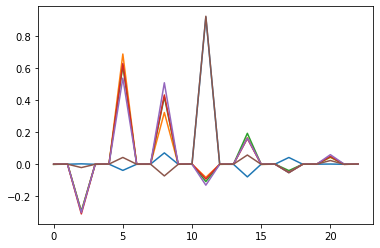

In [52]:
for i in range(len(gcc_phat_data_0)):
    pyplot.plot(gcc_phat_data_0[i][1])